### Business Questions to answer
1. What content netflix generally hosts ?
2. What is the growth of netflix content over the years ?
3. What is the list of countries with most content ?
4. What are the top categories ?
5. Can we recommend titles to users using descriptions ?

### About the data - 
The dataset consists of meta details about the movies and tv shows such as the title, director, and cast of the shows / movies. Details such as the release year, the rating, duration etc are also provided. 

#### Importing neccessary packages and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
import math
import plotly.graph_objects as go
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]



df = pd.read_csv('netflix_titles.csv')

In [2]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [3]:
print("There are about {} total rows in the dataset.".format(df.shape[0]))
print("There are about {} total columns in the dataset.".format(df.shape[1]))

There are about 6234 total rows in the dataset.
There are about 12 total columns in the dataset.


#### Checking null values 

In [4]:
df.isnull().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

#### Checking data types of columns

In [5]:
df.dtypes

show_id          int64
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

### Data Wrangling/Cleaning

#### For country with null values, I will replace them with "Unknown".

In [6]:
df['country'].fillna('Unknown',inplace=True)

In [7]:
##converting date added to datetime for easy plotting
df["date_added"] = pd.to_datetime(df['date_added'])

## adding year and month to the dataset
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['day_added'] = df['date_added'].dt.day


## for movies - converting duration to float minutes
## for tv-series - converting duration to season count
df['season_count'] = df.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else "", axis = 1)
df['duration'] = df.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "", axis = 1)

By looking at the listed in column, one can see there are multiple genre's in a single column, therefore splitting them up will be a good idea

In [8]:
df['genre'] = df['listed_in'].apply(lambda x :  ",".join(str(x).replace(' ,',',').replace(', ',',').split(',')))
df['country'] = df['country'].apply(lambda x :  ",".join(str(x).replace(' ,',',').replace(', ',',').split(',')))

In [9]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,day_added,season_count,genre
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States,India,South Korea,China",2019-09-09,2019,TV-PG,90,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019.0,9.0,9.0,,"Children & Family Movies,Comedies"
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016.0,9.0,9.0,,Stand-Up Comedy
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,,Kids' TV,"With the help of three human allies, the Autob...",2018.0,9.0,8.0,1,Kids' TV
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,,Kids' TV,When a prison ship crash unleashes hundreds of...,2018.0,9.0,8.0,1,Kids' TV
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99,Comedies,When nerdy high schooler Dani finally attracts...,2017.0,9.0,8.0,,Comedies


## Answering Questions

### Q1. What content netflix generally hosts ?

In [10]:
plot_df = pd.DataFrame(df['type'].value_counts()).reset_index()
plot_df.columns = ['Type','Count']

In [11]:

px.pie(plot_df,values='Count',names='Type',title='Number of movies vs number of Tv-Shows')

From the figure above, it is pretty clear that about two thirds of the content on netflix is movies, rest are tv-series.

### Q2. How has the content evolved over time ?

In [12]:
plot_df = df.groupby(['year_added','type']).count()['title'].reset_index()
px.line(plot_df,x='year_added',y='title',color='type',title='content added over years')

In [13]:
## using plotly bar traces

plot_df_mov = plot_df[plot_df['type']=='Movie']
plot_df_tv = plot_df[plot_df['type']=='TV Show']


trace1 = go.Bar(x = plot_df_mov['year_added'], y=plot_df_mov["title"], name="Movie", marker=dict(color="#a678de"))
trace2 = go.Bar(x = plot_df_tv['year_added'], y=plot_df_tv["title"], name="TV Show", marker=dict(color="#6ad49b"))

data = [trace1, trace2]
layout = go.Layout(title="Content added over the years", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

The growth in number of movies on netflix is much higher than that of TV shows. About 1300 new movies were added in both 2018 and 2019. The growth in content started from 2013. Netflix kept on adding different movies and tv shows on its platform over the years. This content was of different variety and from different countries.

### Q3 - What are the countries which produce most content ?

To answer this we will look at the total count of movies/tv-shows produced by each country. Since, there can be multiple countries in a single row, we'll split them and then calculate the counts. For easy plotting, I will be showing only top 15 countries.

In [14]:
## get_dummies converts series to one hot encoded vector. We calculated count of each value by using apply operation
## and then choose the row with index as 1.
subset = df[df['type']=='Movie']
countries_count = subset['country'].str.get_dummies(sep=',').apply(pd.value_counts).iloc[1]
to_plot = pd.DataFrame(countries_count).reset_index()
to_plot.columns = ['country','count of movies']
to_plot.sort_values(by=['count of movies'],inplace=True)

In [15]:
px.bar(to_plot[-15:],x='count of movies',y='country',orientation='h')

We can see that United States produces most movies on Netflix and the second one is India. This makes sense because
Hollywood and Bollywood are the two most recognised film industries in the world.

### Q4 - What are the top categories ?

To answer this we will look at the total count of movies/tv-shows produced in each category. Since, there can be multiple catgegories in a single row, we'll split them and then calculate the counts. For easy plotting, I will be showing only top 15 categories.

In [16]:
## get_dummies converts series to one hot encoded vector. We calculated count of each value by using apply operation
## and then choose the row with index as 1.
subset = df[df['type']=='Movie']
countries_count = subset['genre'].str.get_dummies(sep=',').apply(pd.value_counts).iloc[1]
to_plot = pd.DataFrame(countries_count).reset_index()
to_plot.columns = ['category','count of movies']
to_plot.sort_values(by=['count of movies'],inplace=True)

px.bar(to_plot[-15:],x='count of movies',y='category',orientation='h')

### Q5. Can we recommend movies using its description ?

The purpose is to build a recommendation engine based on graph by using the Adamic Adar measure.
The more the measure is high, the closest are the two nodes.
The measures between all movies are NOT pre-calculated, in order to determine the list of recommendation films, we are going to explore the neighborhood of the target film.

In order to take in account the description, calculate the TF-IDF matrix
and for each film, take the top 5 of similar descriptions and create a node Similar_to_this. This node will be taken in account in the Adamic Adar measure.

In [17]:
## utility fumction
def find_similar_movies(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

In [18]:
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []

df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])


In [19]:
## creating a tf-idf matrix

text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf_full = vector.fit_transform(text_content)

Now we will create a directed acyclic graph, wherein each movie is connected to actor, director, category and it's similar movie (using cosine similarity). In other words - 

Nodes are :

* Movies
* Person ( actor or director)
* Category
* Country
* Sim(title) top 5 similar movies in the sense of the description

Edges are :

* ACTED_IN : relation between an actor and a movie
* CAT_IN : relation between a categrie and a movie
* DIRECTED : relation between a director and a movie
* COU_IN : relation between a country and a movie
* SIMILARITY in the sense of the description

Therefore, two movies are not directly connected, but they share persons, category and countries.

In [20]:
G = nx.Graph(label="MOVIE")
import time 
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))

    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    indices = find_similar_movies(tfidf_full, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))

 iter 0 -- 0.0687870979309082 seconds --
 iter 1000 -- 14.102953910827637 seconds --
 iter 2000 -- 31.40004801750183 seconds --
 iter 3000 -- 45.04841494560242 seconds --
 iter 4000 -- 59.065881967544556 seconds --
 iter 5000 -- 74.4159688949585 seconds --
 iter 6000 -- 89.37842297554016 seconds --
 finish -- 92.99625325202942 seconds --


In [21]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

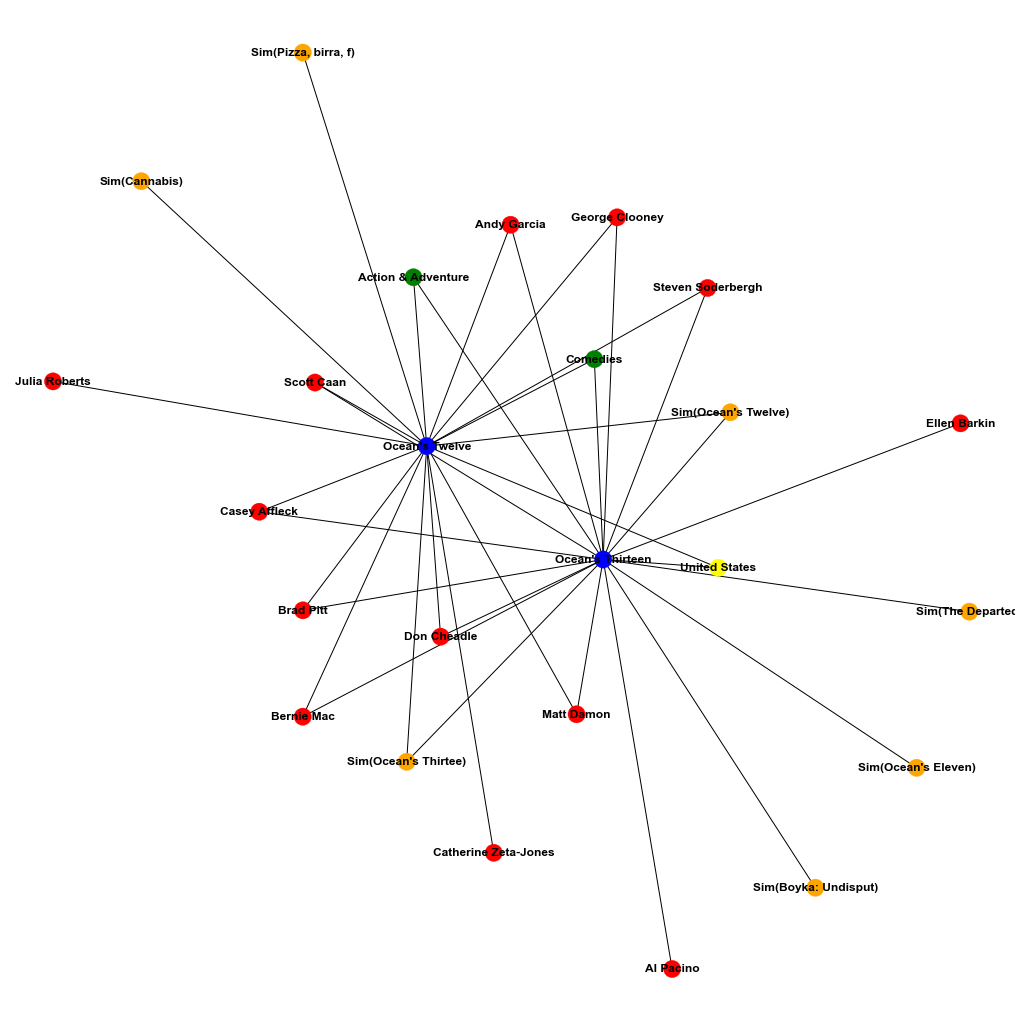

In [22]:
list_in=["Ocean's Twelve","Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

Now to get recommendation - 
1. Explore the neighbours of the target film.
2. For every neighbour, find the movies which share this node.
3. Calculate the metric for each movie.
4. Display top 5 best movie.

In [23]:
## function to get recommendation
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

In [24]:

result = get_recommendation("Ocean's Twelve")
result2 = get_recommendation("Ocean's Thirteen")
result3 = get_recommendation("The Devil Inside")
result4 = get_recommendation("Stranger Things")
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Belmonte'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
Ocean's Thirteen     7.575565
Ocean's Eleven       1.542593
The Informant!       1.346214
Babel                1.199195
The Mask of Zorro    1.194038
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Ocean's Twelve       7.575565
Ocean's Eleven       2.100704
The Departed         1.698527
Brooklyn's Finest    1.492545
Boyka: Undisputed    1.400020
dtype: float64
****************************************
 Recommendation for 'Belmonte'
****************************************
The Devil and Father Amorth              1.423117
Making a Murderer                        1.243407
Belief: The Possession of Janet Moses    1.116221
The Diabolical                           1.032475
The Autopsy of Jane Doe                  1.032475
dtype: float64
****************************************
 Recommenda

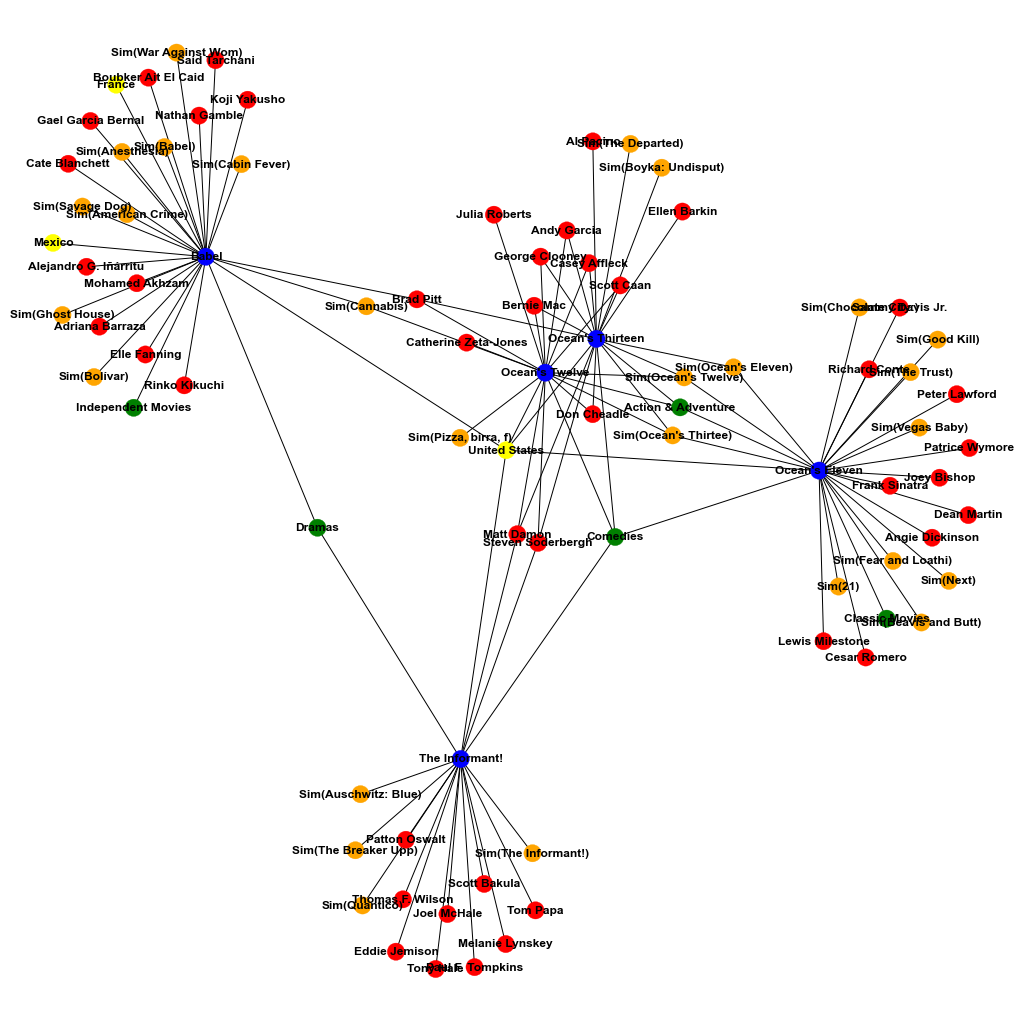

In [25]:
reco=list(result.index[:4].values)
reco.extend(["Ocean's Twelve"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

We can see here all the edges between different nodes of the graph. This concludes our project.

### Conclusion

So, we can see that moveis contribute to about 2/3rd of netflix content. The number of TV Shows has grown over 3 times in the past five years. Also, it is interesting to that documentariy movies are more instead of action and adventure movies. Lastly, we were able to create a recommendation system such that given a movie title it can recommend related movies to it.


### Improvements 
1. Integrating this with user based demographics will definitely help us gain more insights.
2. Integrating this dataset with other external datasets such as IMDB ratings, rotten tomatoes can also help in generating more good recommendations.
3. Comparing this with other streaming services can help us determine where netflix is doing good or doing bad.